In [ ]:
columns_with_missing_values = get_columns_with_missing_values(arg_di_df)
columns_with_missing_values

['sm_pop_refg_or',
 'se_ter_enrr',
 'se_pre_enrr',
 'se_prm_enrr',
 'se_sec_enrr',
 'sp_dyn_le00_in',
 'sh_dth_imrt']

Imputation by K-NN

For using this type of imputation, you must sort the variables by missingness

In [ ]:
knn_imputer = sklearn.impute.KNNImputer(n_neighbors=5)

arg_di_df_knn = arg_di_df.missing.sort_variables_by_missingness(ascending=True).copy()
arg_di_df_knn.iloc[:,:] = knn_imputer.fit_transform(arg_di_df_knn)
arg_di_df_knn.head(5)

ValueError: could not convert string to float: 'Medium'

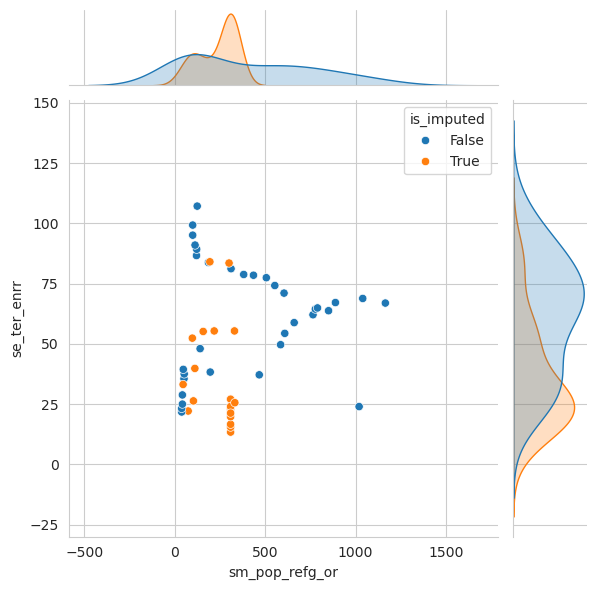

In [ ]:

(
    pd.concat(
        [
            arg_di_df_knn,
            arg_di_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(x=columns_with_missing_values[0], y=columns_with_missing_values[1],show_marginal=True)
)

## Model Based Imputation

### Ordinary Least Squares (OLS)

In [ ]:
(
      # Selects the first table from the summary, which contains high-level model details
)

Dep. Variable:,se_ter_enrr,R-squared:,0.959
Model:,OLS,Adj. R-squared:,0.957
Method:,Least Squares,F-statistic:,461.8
Date:,"Thu, 27 Mar 2025",Prob (F-statistic):,7.04e-28
Time:,21:59:46,Log-Likelihood:,-128.87
No. Observations:,42,AIC:,263.7
Df Residuals:,39,BIC:,269.0
Df Model:,2,,
Covariance Type:,nonrobust,,


In [ ]:
arg_di_df_model = (
    arg_di_df
        .select(columns=["se_ter_enrr", "se_pre_enrr", "se_sec_enrr", "year"])
        .sort_values(by="se_ter_enrr")
        .transform_column( #If a dependent variable has NA values, then they predict NA results
            "se_pre_enrr",
            lambda x: x.ffill(),
            elementwise = False
        )
        .transform_column(
            "se_sec_enrr",
            lambda x: x.ffill(),
            elementwise = False
        )
        .missing.bind_shadow_matrix(
            True,
            False,
            False,
            "_imp"
        )
)

arg_di_df_model.head()

,se_ter_enrr,se_pre_enrr,se_sec_enrr,year,se_ter_enrr_imp,se_pre_enrr_imp,se_sec_enrr_imp,year_imp
0,13.377590,23.44487,44.709621,1970,False,False,False,False
1,15.440980,24.93766,45.642109,1971,False,False,False,False
2,16.620810,26.51997,47.472710,1972,False,False,False,False
3,19.751631,29.06558,49.939709,1973,False,False,False,False
8,21.250999,29.06558,55.343731,1978,False,False,False,False


In [ ]:
se_ter_enrr_ols = (
    arg_di_df_model
        .pipe(
            lambda df: smf.ols(formula="se_ter_enrr ~ se_pre_enrr + se_sec_enrr", data = df)
        )
        .fit()
)

In [ ]:
ols_imputed_values = (
    arg_di_df_model
        .pipe(lambda df: df[df.se_ter_enrr.isna()])
        .pipe(lambda df: se_ter_enrr_ols.predict(df).round())
)

ols_imputed_values

18    44.0
19    44.0
20    46.0
22    46.0
23    46.0
25    46.0
26    49.0
27    46.0
52    46.0
53    46.0
dtype: float64

In [ ]:
arg_di_df_model.loc[arg_di_df_model["se_ter_enrr"].isna(), "se_ter_enrr"] = ols_imputed_values

<Figure size 2000x2000 with 0 Axes>

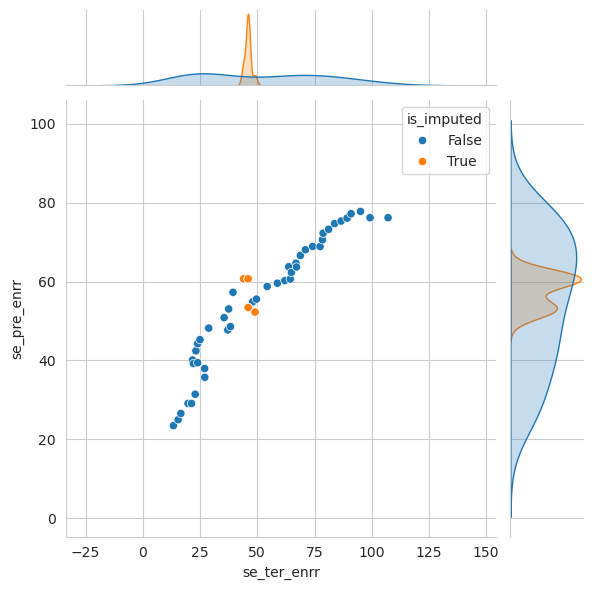

In [ ]:
plt.figure(figsize=(20,20))
arg_di_df_model.missing.scatter_imputation_plot(x="se_ter_enrr",y="se_pre_enrr",show_marginal=True)


## Multiple Imputation by Chained Equations (MICE)

It's a technique for imputing missing data, where multiple possible values are generated for each missing entry using iterative regression models.

By default, Scikit-Learn returns a single dataset, but this can be modified. You must provide values for all variables except the one you want to estimate.

<Axes: xlabel='sm_pop_refg_or', ylabel='se_ter_enrr'>

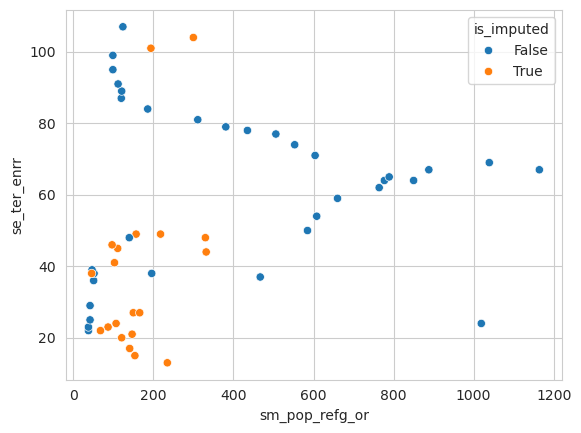

In [ ]:
mice_imputer = sklearn.impute.IterativeImputer(estimator=BayesianRidge())

arg_di_df_mice = arg_di_df_transformed.copy()
arg_di_df_mice.iloc[:,:] = mice_imputer.fit_transform(arg_di_df_mice).round()

arg_di_df_mice = (
    pd.concat(
        [
            arg_di_df_mice,
            arg_di_df.missing.create_shadow_matrix(True,False,True,"_imp")
        ],
        axis=1
    )
)

arg_di_df_mice.missing.scatter_imputation_plot(
    x=columns_with_missing_values[0],
    y=columns_with_missing_values[1]
)

### Inverse transformation of data

In [ ]:
arg_di_df_imputated = arg_di_df_mice.copy()

arg_di_df_imputated[categorical_cols] = (
    categorical_transformer
        .named_transformers_.ordinalencoder.inverse_transform(
            X = arg_di_df_mice[categorical_cols]
        )
)

print(arg_di_df_mice.missing.number_missing())

pd.concat(
    [
        arg_di_df_mice[categorical_cols],
        arg_di_df_imputated[categorical_cols]
    ],
    axis=1
).head(5)

NameError: name 'arg_di_df_mice' is not defined

Source: https://deepnote.com/workspace/platzi-escuela-datos-83832097-f136-43ff-b38d-abaa022e8ec7/project/datos-faltantes-imputacion-bdf84ff9-f66c-44c7-a67c-ca1115a2b683/notebook/imputation-missing-values-60b90530690647e596864b472f71dfde